In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import numpy as np
from tqdm import tqdm

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

## Slices

In [2]:
def plot_silces_multi_runs(r_s, i, k, plot_log=True, save_fn=None, titles=None, shift_mean=False, plot_delta=False, individual_cbar=False):

    plot_n = len(r_s)
    if plot_delta:
        plot_n += 1

    fig, axs = plt.subplots(1, plot_n, figsize=(6*plot_n, 7))
    if plot_n == 1:
        axs = [axs]

    z_s = [r[k][i] for r in r_s]
    if k == 'x_H_slice':
        z_s = [1-z for z in z_s]
    z_mean_s = [np.mean(z) for z in z_s]
    if shift_mean:
        z_s = [z/z_mean_s[i_plot] for i_plot, z in enumerate(z_s)]
    if plot_log:
        z_s = [np.log10(z) for z in z_s]
    vmin = np.quantile(np.concatenate(z_s), 0.02)
    vmax = np.quantile(np.concatenate(z_s), 0.98)

    for i_plot in range(len(r_s)):
        ax = axs[i_plot]
        if individual_cbar:
            im = ax.imshow(z_s[i_plot], origin='lower')
            fig.colorbar(im, ax=ax, orientation='horizontal')
        else:
            im = ax.imshow(z_s[i_plot], origin='lower', vmin=vmin, vmax=vmax)
        title = titles[i_plot] if titles is not None else ''
        ax.set_title(f"{title} mean={z_mean_s[i_plot]:.3e}")

    k_title = k if k != 'x_H_slice' else '1-x_H_slice'
    fig.suptitle(f"{k_title}, $z$={r_s[0]['z'][i]:.3f}")
    if not individual_cbar:
        fig.colorbar(im, ax=axs[:len(r_s)], orientation='horizontal', aspect=len(r_s)*20)
    if plot_delta:
        ax = axs[-1]
        im_delta = ax.imshow(r_s[0]['delta_slice'][i], origin='lower', cmap='binary')
        ax.set_title('delta')
        fig.colorbar(im_delta, ax=axs[-1], orientation='horizontal', aspect=20)

    if save_fn is not None:
        fig.savefig(save_fn)
        plt.close(fig)

In [75]:
run_names = [
    # 'sf_xunifx100_nodplus1_nopop2',
    # 'sf_xunifx100_nodplus1_dc_noLX_nopop2_uddn',
    'sf_xdecayx100_nodplus1_nopop2',
    'sf_xdecayx100_nodplus1_nopop2_Rmax1000_Nshell40',
    'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn',
    # 'sf_xdecayx100_dc_noLX_nodplus1_nopop2_uddn_xrayots',
    # 'sf_xdecayx100_dc_noLX_nodplus1_nopop2_uddn_xrayots_cut500',

    # 'sf_xdecayx100_nodplus1_nopop2_zf001_Rmax32',
    # 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn_zf001_Rmax32',
    # 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn_xrayots_cut500_zf001',
    # 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn_xraybath_cut500_zf001',
]
r_s = [np.load(f"../outputs/dm21cm/{rn}_records.npy", allow_pickle=True).item() for rn in run_names]
# titles = ['21cmFAST', 'DM21cm', 'DM21cm xray OTS', 'DM21cm xray OTS cut500']
titles = run_names

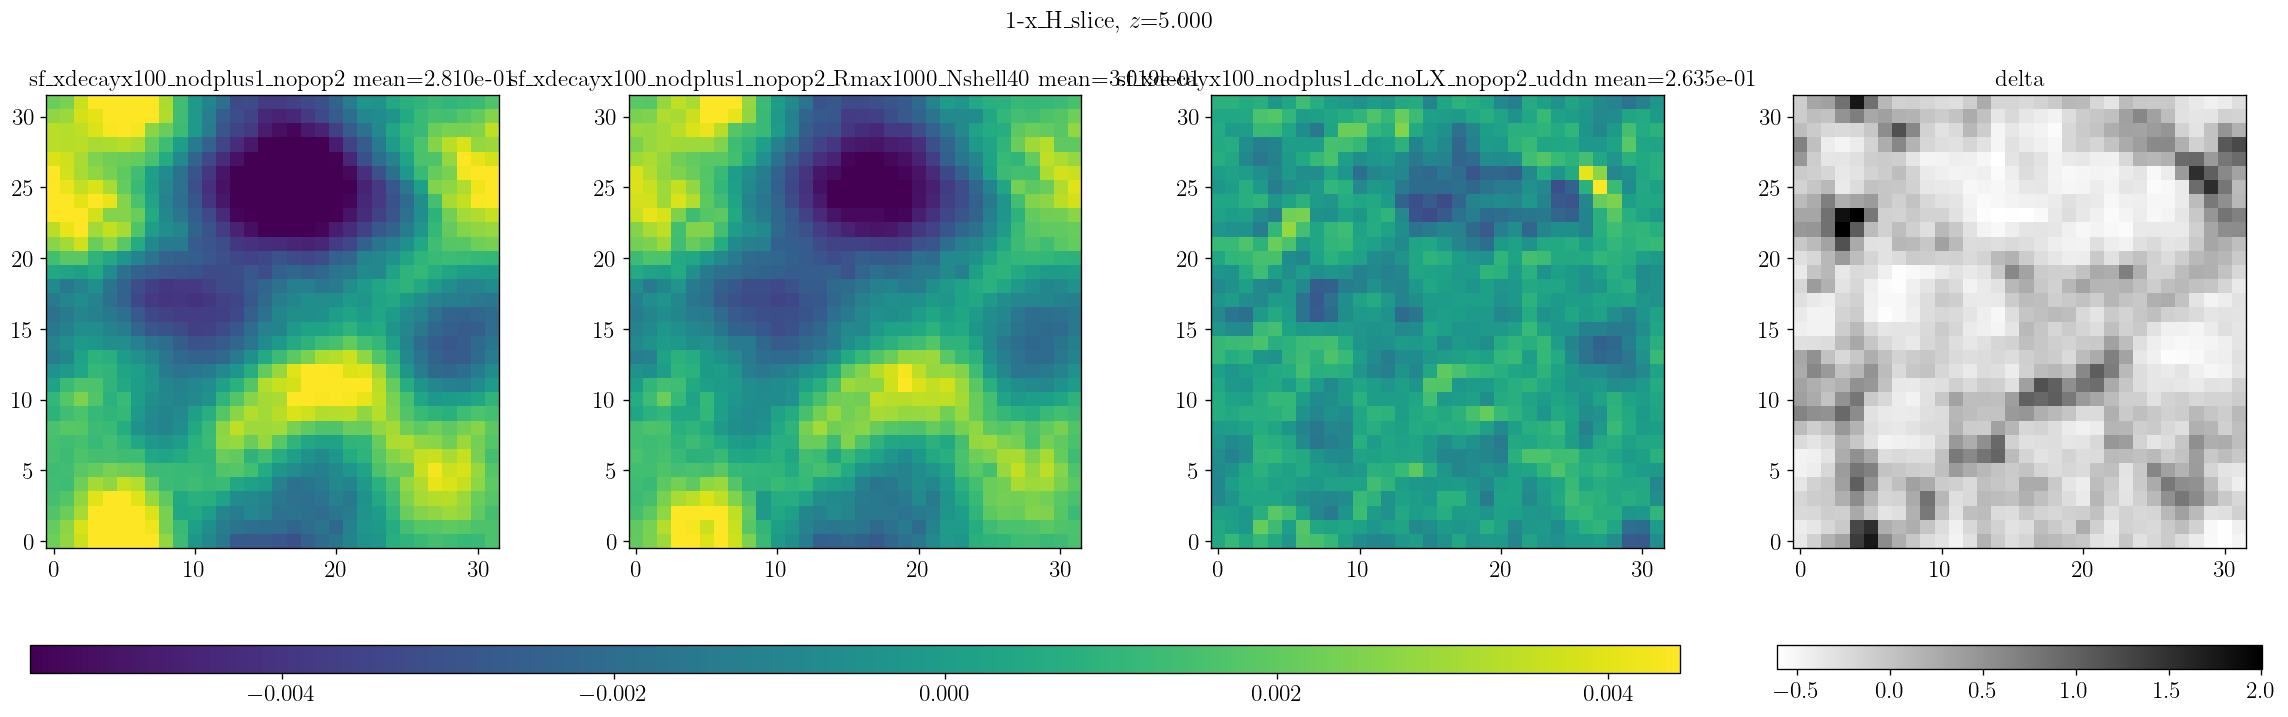

In [76]:
plot_silces_multi_runs(r_s, -1, 'x_H_slice', titles=titles, plot_delta=True, shift_mean=True)

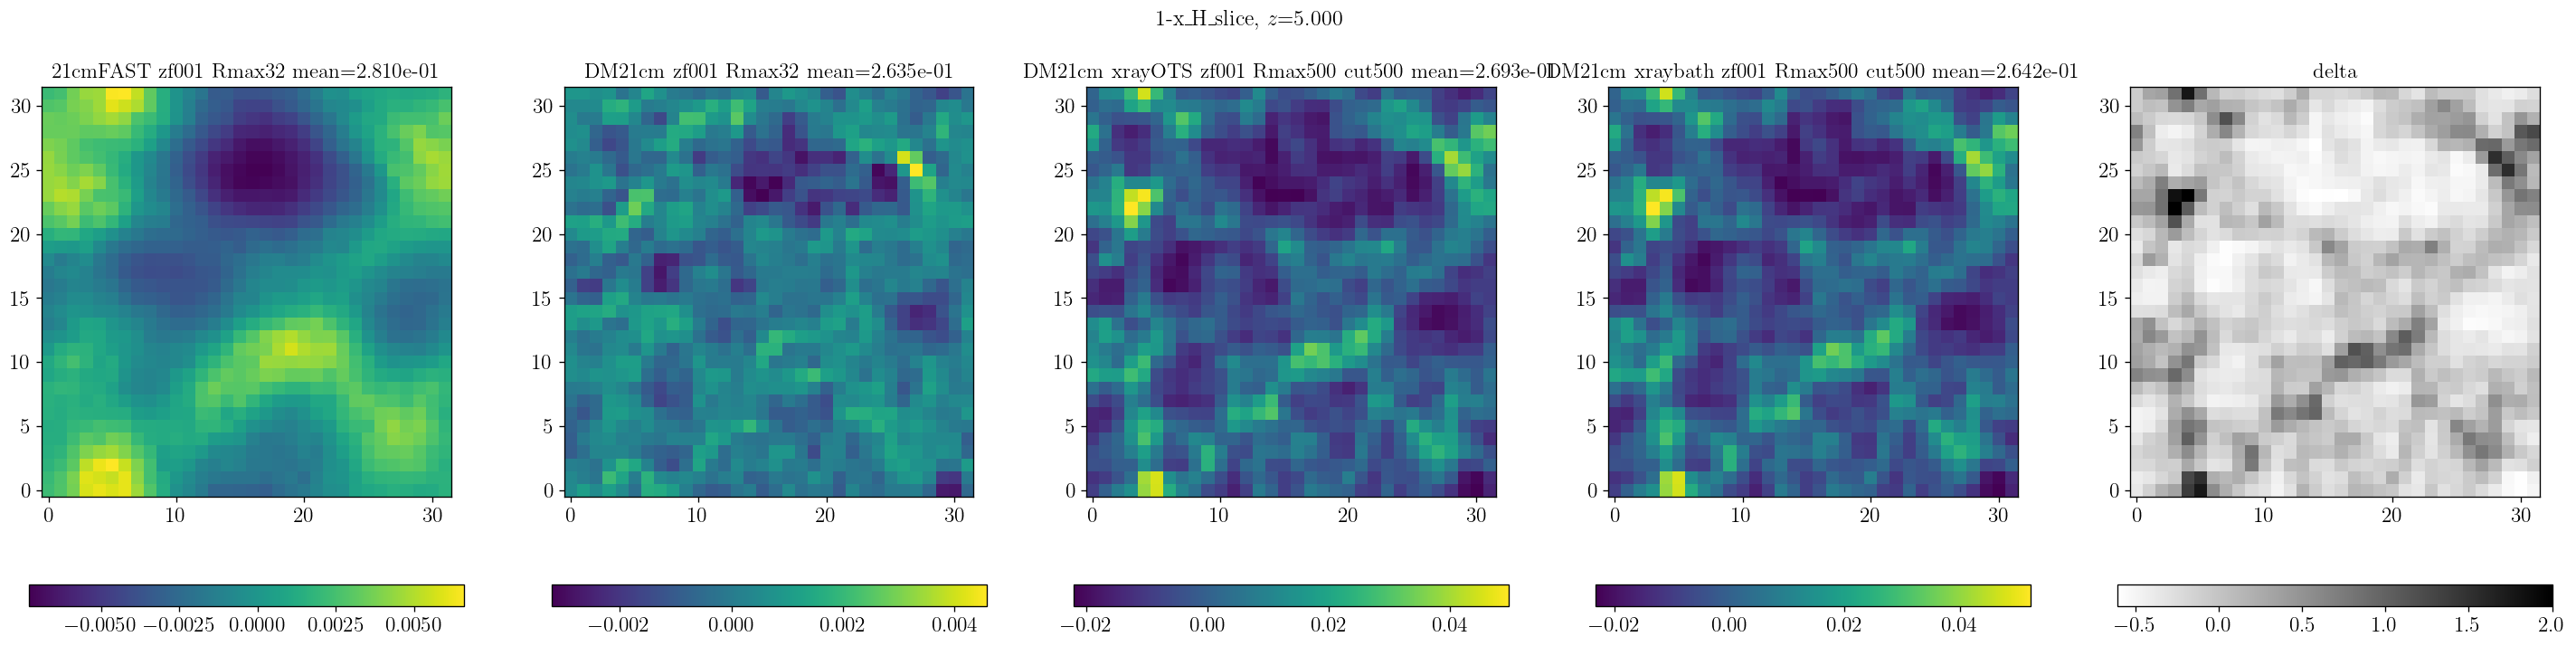

In [44]:
plot_silces_multi_runs(r_s, -1, 'x_H_slice', titles=titles, plot_delta=True, shift_mean=True, individual_cbar=True)

## 2. Shell contribution

In [85]:
sys.path.append("..")
import dm21cm.physics as phys
import py21cmfast as p21c

### 2.1 Shell only

In [123]:
def shell_dc(rec, i, dlogR=False):

    r_out = rec['dep_tracker'][i]['R_shells']
    if dlogR:
        r = np.append(r_out, 0.)
        r = np.insert(r, 0, 2*r[0] - r[1])
        r_diff = np.log10((r[1:] + r[:-1]) / 2)
    else:
        r_diff = np.append(r_out, 0.)
    x = rec['1-x_H'][i]
    norm = 2 / (3*phys.kB*(1+x)) / phys.A_per_B
    dep_heat = rec['dep_tracker'][i]['dep_heat_shells'] # [eV]
    return r_out, norm*dep_heat / np.abs(np.diff(r_diff)) # [Mpc or log10Mpc], [K/Mpc or log10Mpc]

def r_vals_pc(BOX_LEN=64, HII_DIM=32, Rmax=p21c.global_params.R_XLy_MAX, n=p21c.global_params.NUM_FILTER_STEPS_FOR_Ts):
    L_FACTOR = 0.620350491
    R = L_FACTOR * BOX_LEN/HII_DIM
    R_factor = pow(Rmax/R, 1/n)
    r_vals = R * R_factor ** np.arange(n)
    return r_vals

def shell_pc(rec, i, dlogR=False, **kwargs):
    
    r_out = r_vals_pc(**kwargs)
    if dlogR:
        r = np.insert(r_out, 0, 0.)
        r = np.append(r, 2*r[-1] - r[-2])
        r_diff = np.log10((r[1:] + r[:-1]) / 2)
    else:
        r_diff = np.insert(r_out, 0, 0.)
    dep_heat_K = rec['pc_shell_dep_info'][i] # [K]
    return r_out, dep_heat_K / np.abs(np.diff(r_diff)) # [Mpc or log10Mpc], [K/Mpc or log10Mpc]

def get_rec(rn):
    return np.load(f"../outputs/dm21cm/{rn}_records.npy", allow_pickle=True).item()

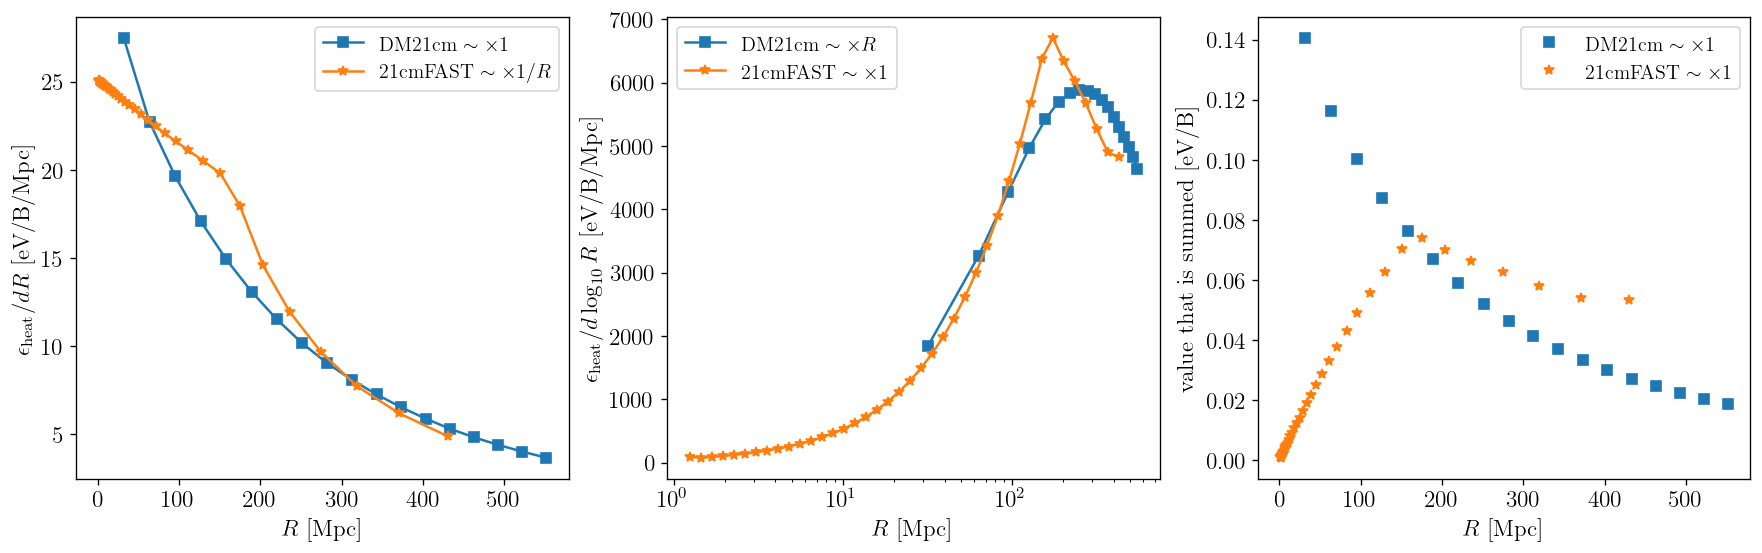

In [134]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

r_dc = get_rec('sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn')
r_pc = get_rec('sf_xdecayx100_nodplus1_nopop2')

ax = axs[0]
ax.plot(*shell_dc(r_dc, -1, dlogR=False), '-s', color='C0', label=r'DM21cm $\sim\times1$')
ax.plot(*shell_pc(r_pc, -1, dlogR=False), '-*', color='C1', label=r'21cmFAST $\sim\times1/R$')
ax.set(xlabel=r'$R$ [Mpc]', ylabel=r'$\epsilon_\mathrm{heat}/dR$ [eV/B/Mpc]')
ax.legend()

ax = axs[1]
ax.plot(*shell_dc(r_dc, -1, dlogR=True), '-s', color='C0', label=r'DM21cm $\sim\times R$')
ax.plot(*shell_pc(r_pc, -1, dlogR=True), '-*', color='C1', label=r'21cmFAST $\sim\times1$')
ax.set(xscale='log')
ax.set(xlabel=r'$R$ [Mpc]', ylabel=r'$\epsilon_\mathrm{heat}/d\log_{10}R$ [eV/B/Mpc]')
ax.legend()

ax = axs[2]
r_out, val = shell_dc(r_dc, -1, dlogR=False)
ax.plot(r_out, val/np.sum(val), 's', color='C0', label=r'DM21cm $\sim\times1$')
r_out, val = shell_pc(r_pc, -1, dlogR=True)
ax.plot(r_out, val/np.sum(val), '*', color='C1', label=r'21cmFAST $\sim\times1$')

ax.set(xlabel=r'$R$ [Mpc]', ylabel=r'value that is summed [eV/B]')
ax.legend()

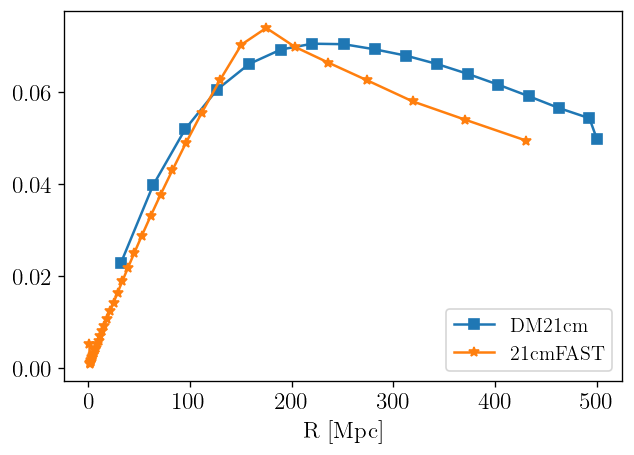

In [ ]:

plt.plot(shellinfo['R2'], shellinfo['R2']*shellinfo['heat']/np.sum(shellinfo['R2']*shellinfo['heat']), '-s', color='C0', label='DM21cm')
plt.plot(r_vals, si_mean/np.sum(si_mean), '-*', color='C1', label='21cmFAST')
#plt.ylim(1e-2, None)
#plt.yscale('log')
plt.xlabel('R [Mpc]')
#plt.ylabel(r'$\epsilon_{ion}/dR$ per B [eV/Mpc]')
plt.legend()

### 2.A shell + bath

In [18]:
rn = 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn_xraybath_cut500_zf001'
r = np.load(f"../outputs/dm21cm/{rn}_records.npy", allow_pickle=True).item()

In [20]:
from dm21cm.evolve import get_z_edges

In [26]:
z_edges = get_z_edges(45, 5, 1.001)[1:]

In [39]:
i_bath_start = len(z_edges) - len(dtr['R_shells']) - len(dtr['bath_toteng_arr'])
i_bath_end = len(z_edges) - len(dtr['R_shells'])
bath_R_s = np.array([phys.conformal_dx_between_z(z_edges[i-1], z_edges[-1]) for i in range(i_bath_start, i_bath_end)])

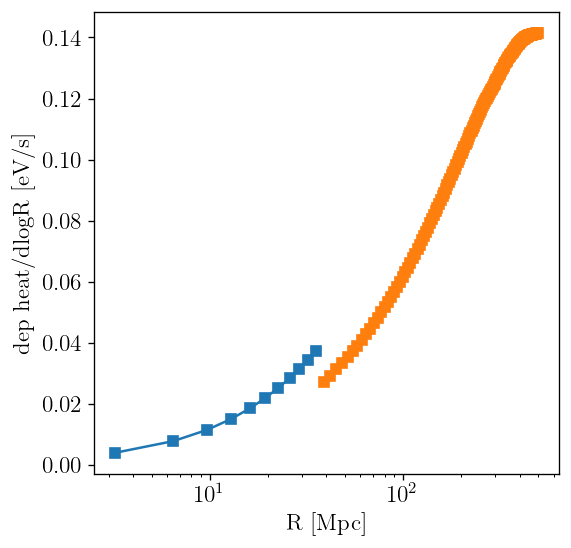

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
ax = axs

dtr = r['dep_tracker'][-1]
ax.plot(dtr['R_shells'], dtr['R_shells']*dtr['dep_heat_shells'], '-s')
ax.set(xlabel='R [Mpc]', ylabel='dep heat/dlogR [eV/s]', xscale='log')

ax.plot(bath_R_s, bath_R_s*dtr['dep_heat_bath']*np.array(dtr['bath_toteng_arr'])/np.sum(dtr['bath_toteng_arr']), '-s')

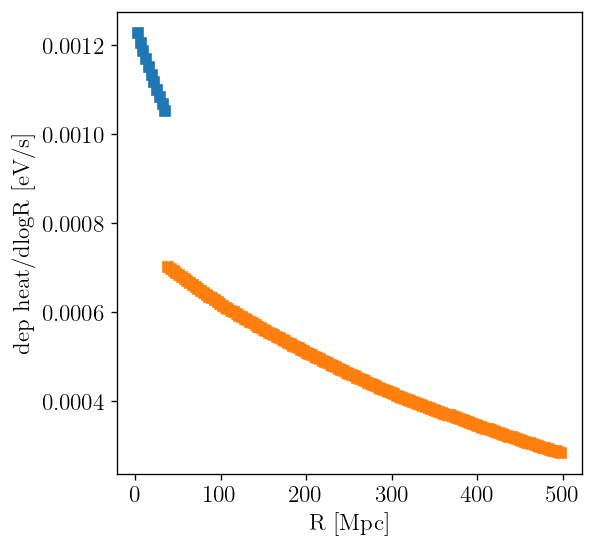

In [41]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
ax = axs

dtr = r['dep_tracker'][-1]
ax.plot(dtr['R_shells'], dtr['dep_heat_shells'], '-s')
ax.set(xlabel='R [Mpc]', ylabel='dep heat/dlogR [eV/s]')

ax.plot(bath_R_s, dtr['dep_heat_bath']*np.array(dtr['bath_toteng_arr'])/np.sum(dtr['bath_toteng_arr']), '-s')

In [ ]:
rn = 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn'
r = np.load(f"../outputs/dm21cm/{rn}_records.npy", allow_pickle=True).item()
shellinfo = r['shell_dep_info'][-1]
x_e_mean = r['x_e'][-1]

In [ ]:
rn2 = 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn_xrayots_cut500_zf001'
r2 = np.load(f"../outputs/dm21cm/{rn2}_records.npy", allow_pickle=True).item()
shellinfo2 = r2['shell_dep_info'][-1]
x_e_mean2 = r2['x_e'][-1]

In [ ]:
rnpc = 'sf_xdecayx100_nodplus1_nopop2'
si = pickle.load(open(f"../outputs/dm21cm/{rnpc}_shellinfo.p", 'rb'))
si_mean = np.mean(si, axis=(1, 2, 3))

In [53]:
sys.path.append("..")
import dm21cm.physics as phys
import py21cmfast as p21c

In [ ]:
plt.plot(si_mean, '*', color='C1')
plt.ylabel("dT")
plt.xlabel("shell number")

In [ ]:
global_params = p21c.global_params

L_FACTOR = 0.620350491
BOX_LEN = 64
HII_DIM = 32
R = L_FACTOR* BOX_LEN/HII_DIM
R_factor = pow(global_params.R_XLy_MAX/R, 1/global_params.NUM_FILTER_STEPS_FOR_Ts)

r_vals = R*R_factor**np.arange(40)

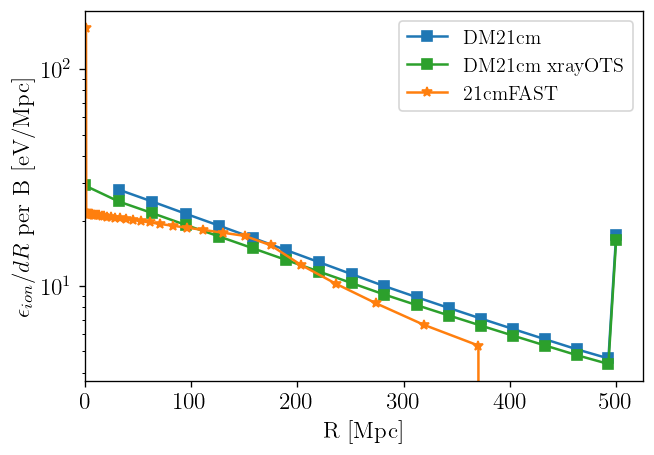

In [ ]:
R_DC = np.concatenate([shellinfo['R2'], np.array([0.])])
norm = 2 / (3*phys.kB*(1+x_e_mean)) / phys.A_per_B
plt.plot(R_DC[:-1], norm*shellinfo['heat']/np.abs(np.diff(R_DC)), '-s', color='C0', label='DM21cm')

R_DC2 = np.concatenate([shellinfo2['R2'], np.array([-31.])])
norm2 = 2 / (3*phys.kB*(1+x_e_mean2)) / phys.A_per_B
plt.plot(R_DC2[:-1], norm2*shellinfo2['heat']/np.abs(np.diff(R_DC2)), '-s', color='C2', label='DM21cm xrayOTS')

R_PC = np.concatenate([r_vals, np.array([0.])])
plt.plot(R_PC[:-1], si_mean/np.diff(R_PC), '-*', color='C1', label='21cmFAST')
plt.xlim(0, None)
plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel(r'$\epsilon_{ion}/dR$ per B [eV/Mpc]')
plt.legend()

## GIF

In [24]:
for i in range(0, 200, 5):
    plot_silces_multi_runs(i, 'x_H_slice', titles=run_names, plot_delta=True, save_fn=f"plots/slices/tmp/{i}.png")

In [25]:
from PIL import Image

def create_gif_from_filelist(file_list, output_gif_path, interval_time):
    images = [Image.open(file_path) for file_path in file_list]
    images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration=interval_time * 1000, loop=0)

In [26]:
flist = []
for i in np.arange(0, 200, 5):
    flist.append(f"plots/slices/tmp/{i}.png")

create_gif_from_filelist(flist, "x_H.gif", 0.5)

## A1. Global

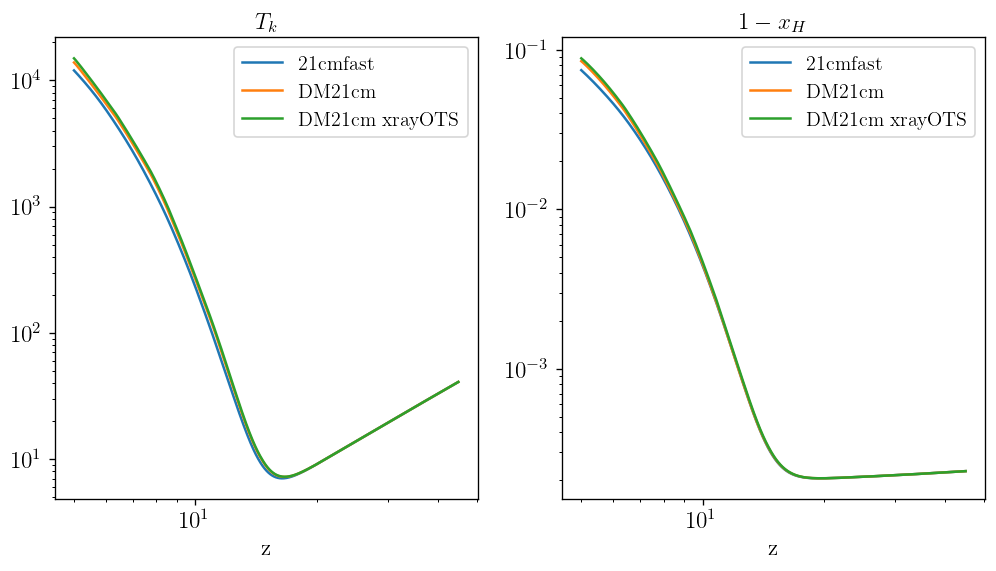

In [ ]:
labels=['21cmfast', 'DM21cm', 'DM21cm xrayOTS']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
for r, rn in zip(r_s, labels):
    ax.plot(r['z'], r['T_k'], label=rn)
ax.set(title='$T_k$', xlabel='z')
ax.set(xscale='log', yscale='log')
ax.legend()

ax = axs[1]
for r, rn in zip(r_s, labels):
    ax.plot(r['z'], r['1-x_H'], label=rn)
ax.set(title='$1-x_H$', xlabel='z')
ax.set(xscale='log', yscale='log')
ax.legend()